# Get Actions and Definitions data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

In [ ]:
#NE PAS MODIFIER CETTE CELL
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
#NE PAS MODIFIER CETTE CELL
actions = pd.read_csv('/content/drive/MyDrive/DATA/actions_test_enc.csv')
definitions = pd.read_csv('/content/drive/MyDrive/DATA/definitions_test_enc.csv')

# Parse Planning stream stop

In [ ]:
# GET PLANNING STREAM STOP - PARSE PROPERTIES TO GET DURATION, PLANNING ID
# 비디오 시청 정지를 한 데이터들만 모은 테이블
# 비디오 시청시간 데이터프레임에서 시청시간과 비디오 아이디를 추출
planning_stream_stop = actions.loc[actions['type'] == 'planning_stream_stop']
planning_stream_stop['watch_time'] = planning_stream_stop.apply(lambda x: json.loads(x['properties'])['duration'],axis=1)
planning_stream_stop['planning_id'] = planning_stream_stop.apply(lambda x: json.loads(x['properties'])['planning_id'],axis=1)

In [ ]:
planning_stream_stop.head(5)

,time,type,platform,user_id,properties,watch_time,planning_id
345207,2020-08-06 19:47:48.993000,planning_stream_stop,web-user,f81b5b784bdda931d7141bc61708fcba,"{""duration"": 1592254, ""planning_id"": ""fb6cf6cf...",1592254,fb6cf6cfa9b32c86a51532bf285e6bc1
345208,2020-08-06 13:54:20.662000,planning_stream_stop,web-user,4445d65ea20f875a7ed66d1846f9d514,"{""duration"": 12862, ""planning_id"": ""761c2dda94...",12862,761c2dda948a2d9966e844882dbd9350
345209,2020-08-10 07:24:06.161000,planning_stream_stop,web-user,05f97b684ccc1c502d6545a3dc35c5c6,"{""duration"": 77150, ""planning_id"": ""a59a2d463d...",77150,a59a2d463db07e7237e359e4c43fa2c1
345210,2020-08-06 23:01:45.139000,planning_stream_stop,web-user,e82f4ceb9f7c324a9c3275c367d00bdc,"{""duration"": 2049062, ""planning_id"": ""5024d8dc...",2049062,5024d8dc0a17b02c00c3389a4071ba52
345211,2020-08-06 17:50:46.016000,planning_stream_stop,web-user,2063e6ff5d24392f0d9b1a75942433f4,"{""duration"": 2963678, ""planning_id"": ""21209ce8...",2963678,21209ce8580ed1d11ac5b39468a9209d


# Get Planning Durations from Definitions

In [ ]:
# GET PLANNING DURATION FROM DEFINITIONS
definitions_planning = definitions.loc[definitions['type'] == 'planning']
definitions_planning['planning_duration']=definitions_planning.apply(lambda x: pd.to_numeric(json.loads(x['properties'])['duration']),axis=1)
definitions_planning = definitions_planning.rename(columns={"id":"planning_id"})
definitions_planning = definitions_planning.drop(['type','properties'], axis=1)

In [ ]:
definitions_planning.head(5)

,planning_id,planning_duration
22489,74fb943f6d41fe1682c0b6413195482d,3600000
22490,b3c0e4cb450785785ac1eb55fe557a5f,2400000
22491,a775996b4a6d760d9d8f47d6105833bc,2400000
22492,a59a2d463db07e7237e359e4c43fa2c1,2400000
22493,42fd4b402caa9d9b977011c96e634a7d,2400000


In [ ]:
definitions_planning['planning_duration'].describe()

count    3.120000e+02
mean     1.153231e+07
std      2.318570e+07
min      6.000000e+05
25%      2.400000e+06
50%      2.400000e+06
75%      3.600000e+06
max      1.080000e+08
Name: planning_duration, dtype: float64

# Get watch time percentage

In [ ]:
# GET PERCENTAGE OF WATCH TIME
actions_videos = pd.merge(planning_stream_stop, definitions_planning, how='left', on='planning_id')
actions_videos['view_duration_percentage'] = round((actions_videos['watch_time']*100)/actions_videos['planning_duration'],2)
actions_videos = actions_videos.drop(['type','properties'], axis=1)
actions_videos.head(5)

,time,platform,user_id,watch_time,planning_id,planning_duration,view_duration_percentage
0,2020-08-06 19:47:48.993000,web-user,f81b5b784bdda931d7141bc61708fcba,1592254,fb6cf6cfa9b32c86a51532bf285e6bc1,2400000.0,66.34
1,2020-08-06 13:54:20.662000,web-user,4445d65ea20f875a7ed66d1846f9d514,12862,761c2dda948a2d9966e844882dbd9350,28800000.0,0.04
2,2020-08-10 07:24:06.161000,web-user,05f97b684ccc1c502d6545a3dc35c5c6,77150,a59a2d463db07e7237e359e4c43fa2c1,2400000.0,3.21
3,2020-08-06 23:01:45.139000,web-user,e82f4ceb9f7c324a9c3275c367d00bdc,2049062,5024d8dc0a17b02c00c3389a4071ba52,1800000.0,113.84
4,2020-08-06 17:50:46.016000,web-user,2063e6ff5d24392f0d9b1a75942433f4,2963678,21209ce8580ed1d11ac5b39468a9209d,2400000.0,123.49


# Unreasonable video watch time

In [ ]:
# CHECK UNRESONABLE VIDEO WATCH TIME
unreasonable_time_videos = actions_videos.loc[actions_videos['view_duration_percentage'] > 100]
unreasonable_time_videos.shape[0]

17823

# Percentage of completion of video

In [ ]:
# GET 90PERCETAGE OR MORE WATCHING USER
planning_stream = actions_videos.loc[(actions_videos['view_duration_percentage'] >= 90) & (actions_videos['view_duration_percentage'] <= 100)]
cnt_users_completion_video = planning_stream.shape[0]
print("Percentage of completion of a video is : ", round(cnt_users_completion_video*100/actions_videos.shape[0],2), '%')

Percentage of completion of a video is :  3.71 %


# Count of users by video watch time (%)

Text(0.5, 1.0, 'Users by video watching time (%)')

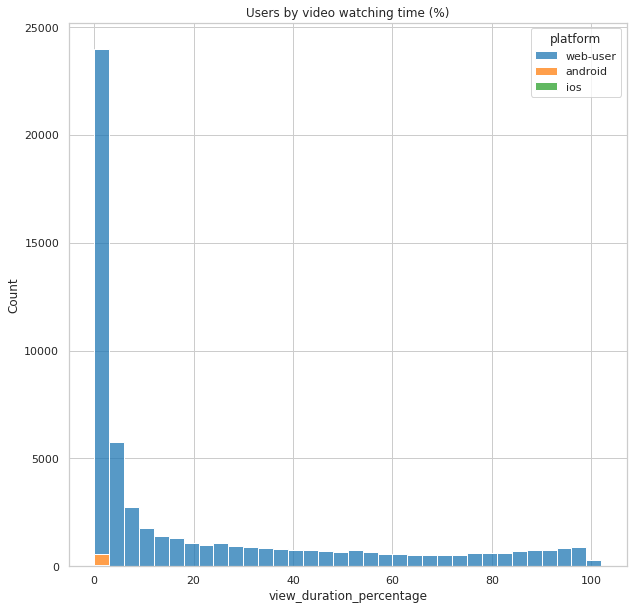

In [ ]:
# GET COUNT OF USER BY VIDEO WATCHING TIME (%)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2})
plt.figure(figsize=(10,10))
videos = actions_videos.loc[(actions_videos['view_duration_percentage'] <= 100) & (actions_videos['view_duration_percentage'] >= 0)]
sns.histplot(data=videos, x="view_duration_percentage", binwidth=3, hue="platform", multiple="stack")
plt.title("Users by video watching time (%)")

# Average watch time (%) by each video

In [ ]:
# 각 비디오(0-100%)별 평균 시청시간
# AVERAGE WATCH TIME FOR EACH VIDEO (0-100%)
mean_planning = videos.groupby(by=['planning_id'], as_index=False).agg({'watch_time':'mean'})
mean_planning = mean_planning.rename(columns={"watch_time": "mean_watch_time"})
mean_planning['mean_watch_time_convert'] = mean_planning.apply(lambda x: datetime.timedelta(milliseconds=x['mean_watch_time']),axis=1)
mean_planning['mean_watch_time_delta'] = mean_planning.apply(lambda x:str(x['mean_watch_time_convert']).split('days')[1],axis=1)
mean_planning = mean_planning.drop(['mean_watch_time_convert'], axis=1)

In [ ]:
# CALCUL PERCENTAGE
mean_planning = pd.merge(mean_planning, definitions_planning, how='left', on='planning_id')
mean_planning['mean_view_duration_percentage'] = round((mean_planning['mean_watch_time']*100)/mean_planning['planning_duration'],2)
mean_planning

,planning_id,mean_watch_time,mean_watch_time_delta,planning_duration,mean_view_duration_percentage
0,02d2df6ac3dd7f22355942efd42936e6,396666.141791,00:06:36.666142,1200000,33.06
1,03542d6d2561988d426ed5eef4a52e4c,580419.786885,00:09:40.419787,2400000,24.18
2,03a33949ee6292d301b0468115649002,691459.317568,00:11:31.459318,3600000,19.21
3,0460f1a6dfbcee9e4fd1f993ddef481a,593465.688073,00:09:53.465688,2400000,24.73
4,05f273e5191a6df4080469b5da3d4ec6,734570.255319,00:12:14.570255,2400000,30.61
...,...,...,...,...,...
288,facef6954c12f990e293f4084b7ba21c,747207.496855,00:12:27.207497,2400000,31.13
289,fb6cf6cfa9b32c86a51532bf285e6bc1,461604.325581,00:07:41.604326,2400000,19.23
290,fbc15feae00ee10cab64986438e0bf71,290437.400000,00:04:50.437400,1200000,24.20
291,fd5a9d33c2dff8adf973741216f33d57,687766.708075,00:11:27.766708,2400000,28.66


Text(0.5, 1.0, 'Average watch time (%)')

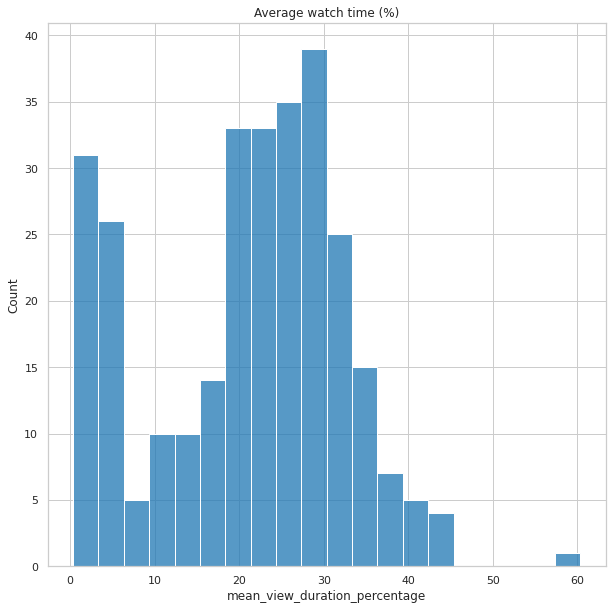

In [ ]:
# MEAN WATCHING TIME (%)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2})
plt.figure(figsize=(10,10))
sns.histplot(data=mean_planning, x="mean_view_duration_percentage", binwidth=3, multiple="stack")
plt.title('Average watch time (%)')

# Count of Users by Planning

In [ ]:
users_by_planning = actions_videos.groupby(by=['planning_id'], as_index=False).agg({'user_id':'count'})
plannings_users = pd.merge(mean_planning, users_by_planning, how='left', on='planning_id')
plannings_users = plannings_users.rename(columns={"user_id": "nb_users"})
plannings_users

,planning_id,mean_watch_time,mean_watch_time_delta,planning_duration,mean_view_duration_percentage,nb_users
0,02d2df6ac3dd7f22355942efd42936e6,396666.141791,00:06:36.666142,1200000,33.06,175
1,03542d6d2561988d426ed5eef4a52e4c,580419.786885,00:09:40.419787,2400000,24.18,342
2,03a33949ee6292d301b0468115649002,691459.317568,00:11:31.459318,3600000,19.21,167
3,0460f1a6dfbcee9e4fd1f993ddef481a,593465.688073,00:09:53.465688,2400000,24.73,184
4,05f273e5191a6df4080469b5da3d4ec6,734570.255319,00:12:14.570255,2400000,30.61,269
...,...,...,...,...,...,...
288,facef6954c12f990e293f4084b7ba21c,747207.496855,00:12:27.207497,2400000,31.13,215
289,fb6cf6cfa9b32c86a51532bf285e6bc1,461604.325581,00:07:41.604326,2400000,19.23,142
290,fbc15feae00ee10cab64986438e0bf71,290437.400000,00:04:50.437400,1200000,24.20,101
291,fd5a9d33c2dff8adf973741216f33d57,687766.708075,00:11:27.766708,2400000,28.66,257


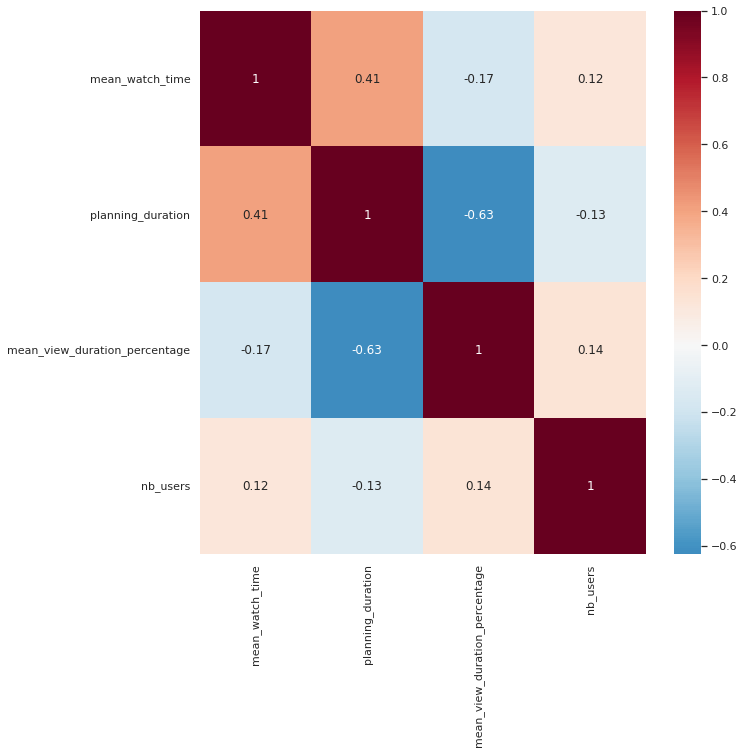

In [ ]:
# CORRELATION BETWEEN VARIABLES
plt.figure(figsize=(10,10))
sns.heatmap(plannings_users.corr(), annot=True, cmap='RdBu_r', center=0)

# Planning duration and Users

In [ ]:
plannings_users = plannings_users.sort_values(by='nb_users', ascending=False)
plannings_users

,planning_id,mean_watch_time,mean_watch_time_delta,planning_duration,mean_view_duration_percentage,nb_users
155,9055e07f399e6bd4887ef9e699d14344,8.118750e+05,00:13:31.874985,3600000,22.55,5567
128,7650dd8d75951f31537ad98168741bc9,1.509850e+06,00:25:09.849817,3600000,41.94,2651
148,88a9af05bb7cb1348882b757205f705a,4.328216e+05,00:07:12.821583,1800000,24.05,1059
95,4fa1678fe08b2394389995850b2107af,5.119512e+05,00:08:31.951151,7200000,7.11,1018
140,80b4db283d91a09d4938b5070f0a7865,6.234840e+05,00:10:23.483999,2400000,25.98,941
...,...,...,...,...,...,...
231,ca7a51b72096734272db7706ae1f9b80,1.761088e+05,00:02:56.108846,900000,19.57,16
7,0749de94af439375eff292780b1b62f7,1.005348e+05,00:01:40.534750,900000,11.17,14
107,62924e7a2b3131ad059e219d815f76a5,4.900853e+05,00:08:10.085308,840000,58.34,13
62,31d7f361e09e6a93a51784757fbeb0b1,2.859855e+05,00:04:45.985500,3900000,7.33,4


Text(0.5, 1.0, 'Bookmark and Exhibitor Show')

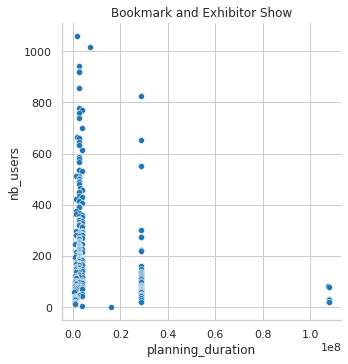

In [ ]:
# PLANNING DURATION AND COUNT OF USERS
sns.relplot(x='planning_duration', y='nb_users', data=plannings_users.iloc[2:])
plt.title("Bookmark and Exhibitor Show")